In [1]:
import matplotlib.pyplot as plt
import numpy as np

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [3]:
PATH_SAM="../../../Dati/Spettri_Sam/Noise/Run_X_50_5000_ChargeHistos_5_30_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)
    
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

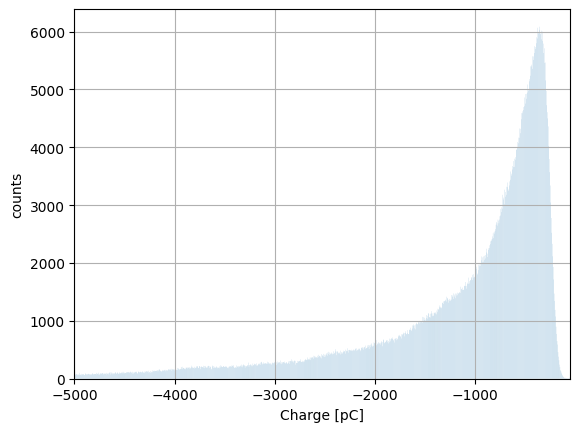

In [4]:
lim_N = [-5000, -50]
plt.bar(centers_N, bin_N, width = 1, snap = False, alpha = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [5]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [6]:
np.where(err_N == 0)

(array([], dtype=int64),)

In [7]:
from lmfit.models import GaussianModel, ExponentialModel, StepModel
from lmfit import Model

#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
exp2   = ExponentialModel(prefix='e2_') #Esponenziale 
exp3   = ExponentialModel(prefix='e3_') #Esponenziale 

sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)
params.update(exp2.guess(bin_N, x=centers_N))
params.update(exp3.guess(bin_N, x=centers_N))

params.update(sigmoid1.guess(bin_N, x=centers_N))


params["e1_decay"].value = -370
params["e1_amplitude"].value = 12500

params["e2_decay"].value = -1500
params["e2_amplitude"].value = 2000

params["e3_decay"].value = -1500
params["e3_amplitude"].value = 2000


params["e1_amplitude"].min = 9500
params["e1_amplitude"].max = 13500

params["e2_amplitude"].min = 500
params["e2_amplitude"].max = 2500


params["e1_decay"].min = -400
params["e1_decay"].max = -300

params["e2_decay"].min = -1600
params["e2_decay"].min = -1400


params["s1_amplitude"].value = 1
params["s1_amplitude"].vary = False

params["s1_center"].value = -255  

params["s1_center"].max = 0
params["s1_center"].min = -1000  

params["s1_sigma"].max = 35
params["s1_sigma"].min = 0





def const1(x):
    return 1


model = (exp1 + exp2 + exp3) * (Model(const1) - sigmoid1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


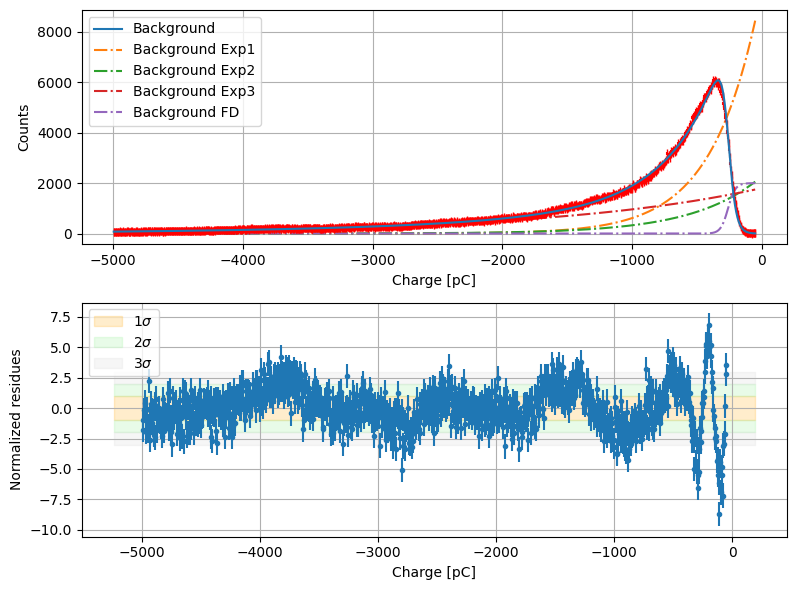

In [8]:
#FIT

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti

ax1.plot(centers_N, (comps['e1_'] + comps['e2_'] + comps['e3_']) * (1 - comps['s1_']), label='Background', zorder = 10)
ax1.plot(centers_N, comps['e1_'], label='Background Exp1', ls = "-.")
ax1.plot(centers_N, comps['e2_'], label='Background Exp2', ls = "-.")
ax1.plot(centers_N, comps['e3_'], label='Background Exp3', ls = "-.")

ax1.plot(centers_N, comps['s1_'] * 2000, label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [9]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(exponential, prefix='e2_')) + Model(exponential, prefix='e3_')) * (Model(const1) - Model(step, prefix='s1_', form='logistic')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 539
    # data points      = 1000
    # variables        = 8
    chi-square         = 3144.10186
    reduced chi-square = 3.16945752
    Akaike info crit   = 1161.52827
    Bayesian info crit = 1200.79031
    R-squared          = 0.99999831
[[Variables]]
    e1_amplitude:  9756.35018 +/- 22875.4227 (234.47%) (init = 12500)
    e1_decay:     -361.740113 +/- 176.530487 (48.80%) (init = -370)
    e2_amplitude:  2277.13495 +/- 22900.2233 (1005.66%) (init = 2000)
    e2_decay:     -516.478156 +/- 991.801206 (192.03%) (init = -1400)
    e3_amplitude:  1804.08598 +/- 382.617171 (21.21%) (init = 2000)
    e3_decay:     -1583.26088 +/- 106.431339 (6.72%) (init = -1500)
    s1_amplitude:  1 (fixed)
    s1_center:    -261.317098 +/- 0.758